In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import os
from itertools import product
import copy
import sys

!rm -r /kaggle/working/Architectural-Biases-in-Time-Series-Anomaly-Detection
!git clone https://github.com/KirillVishnyakov/Architectural-Biases-in-Time-Series-Anomaly-Detection

Cloning into 'Architectural-Biases-in-Time-Series-Anomaly-Detection'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (32/32), done.
Receiving objects: 100% (40/40), 7.88 KiB | 7.88 MiB/s, done.
Resolving deltas: 100% (18/18), done.
remote: Total 40 (delta 18), reused 25 (delta 6), pack-reused 0 (from 0)


### Import necessary functions/modules from git repository

In [3]:
sys.path.append("/kaggle/working/Architectural-Biases-in-Time-Series-Anomaly-Detection")
import train
from dataset import myDataset
from lstm import myLSTM
from utils import load_config

### load device, datasets, config into environment.

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
train_dataset = myDataset(device, 5)
test_dataset = myDataset(device, 5, False)
base_config = load_config("/kaggle/working/Architectural-Biases-in-Time-Series-Anomaly-Detection/lstm_short_window.yaml")

### Train and save results of multiple experiments

In [20]:
num_layers_list = [1, 2, 3]
lr_list = [1e-3, 5e-4]
batch_sizes = [5, 10, 20, 30]
dropouts = [0.0, 0.1, 0.25]

training_results = dict()

for nl, lr, bs, dr in product(num_layers_list, lr_list, batch_sizes, dropouts):
    config = copy.deepcopy(base_config)
    
    config["model"]["num_layers"] = nl
    config["model"]["dropout"] = dr
    config["training"]["lr"] = lr
    config["training"]["batch_size"] = bs
    
    config["experiment_name"] = f"l{nl}_lr{lr}_bs{bs}_dr{dr}"
    model = myLSTM(**config["model"]).to(device)
    training_results[config["experiment_name"]] = \
    train.train_lstm(model, config["experiment_name"], train_dataset, test_dataset, **config["training"])
    print()
    

| experiment: l1_lr0.001_bs10_dr0.1 | epoch 0, train: MSE 0.1078, test MSE: 0.1663
| experiment: l1_lr0.001_bs10_dr0.1 | epoch 1, train: MSE 0.0950, test MSE: 0.1549
| experiment: l1_lr0.001_bs10_dr0.1 | epoch 2, train: MSE 0.0921, test MSE: 0.1483
| experiment: l1_lr0.001_bs10_dr0.1 | epoch 3, train: MSE 0.0883, test MSE: 0.1474
| experiment: l1_lr0.001_bs10_dr0.1 | epoch 4, train: MSE 0.0871, test MSE: 0.1469

| experiment: l1_lr0.001_bs20_dr0.1 | epoch 0, train: MSE 0.1035, test MSE: 0.1634
| experiment: l1_lr0.001_bs20_dr0.1 | epoch 1, train: MSE 0.0736, test MSE: 0.1281
| experiment: l1_lr0.001_bs20_dr0.1 | epoch 2, train: MSE 0.0623, test MSE: 0.1113
| experiment: l1_lr0.001_bs20_dr0.1 | epoch 3, train: MSE 0.0611, test MSE: 0.1072
| experiment: l1_lr0.001_bs20_dr0.1 | epoch 4, train: MSE 0.0596, test MSE: 0.1093



## Analyzing model outputs

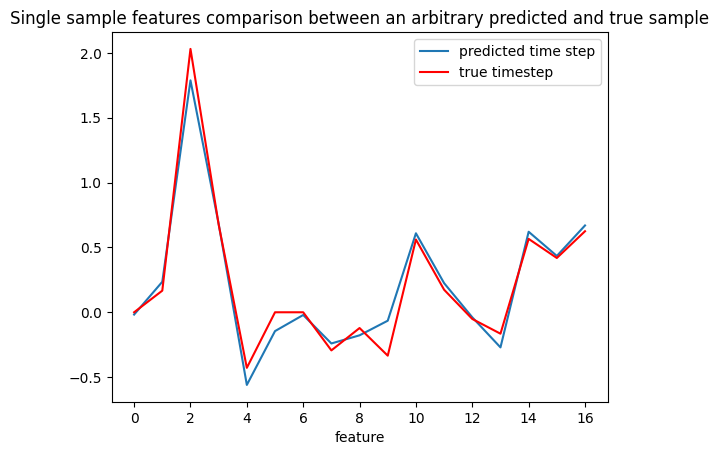

In [23]:
model.load_state_dict(training_results['l1_lr0.001_bs10_dr0.1'][0])
with torch.no_grad():
    random_idx = 1000
    random_pred = model(test_dataset[random_idx][0].unsqueeze(dim = 0))
    real = test_dataset[random_idx][1]
plt.plot(random_pred.cpu().detach().numpy()[0], label = "predicted time step")
plt.plot(real.cpu().detach().numpy(), c = "red", label = "true timestep")
plt.xlabel("feature")
plt.legend()
plt.title("Single sample features comparison between an arbitrary predicted and true sample")
plt.show()

## Now for all data points, requires dimensionality reduction. Choosing 3d to preserve the most variance possible.

In [ ]:
"""y_true_array = test_dataset.y.cpu().detach().numpy()
y_pred_array = model(test_dataset.X).cpu().detach().numpy()
pca = PCA(n_components = 3)
true_3d = pca.fit_transform(y_true_array)
pred_3d = pca.transform(y_pred_array)
print(pca.explained_variance_ratio_.sum())"""

In [ ]:
"""step = 200
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d') 

ax.plot(true_3d[::step,0], true_3d[::step,1], true_3d[::step,2], c='r', linewidth=0.8, label = "true y")
ax.plot(pred_3d[::step,0], pred_3d[::step,1], pred_3d[::step,2], c='b', linewidth=0.8, linestyle = 'dashed', label = "predicted y")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.title('reduced true features vs reduced predicted features 3D')
plt.legend()
plt.show()"""